---
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><Deeplab Model</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Teamleden</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://fishpassapp.co.uk/img/biosecurity/giant-hogweed-v2.png" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.applications import DenseNet121

In [2]:
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
IMAGE_PATH = 'self-labeled data/image_patches'
MASK_PATH = 'self-labeled data/mask_patches'

def load_data(image_path, mask_path):
    images = []
    masks = []
    for image_name in os.listdir(image_path):
        image = img_to_array(load_img(os.path.join(image_path, image_name), target_size=(256, 256)))
        mask = img_to_array(load_img(os.path.join(mask_path, image_name), target_size=(256, 256), color_mode="grayscale"))
        if np.any(mask):  # Controleer of het masker niet leeg is
            images.append(image)
            masks.append(mask)
        else:
            print(f"Leeg masker gevonden: {image_name}")
    return np.array(images), np.array(masks)

images, masks = load_data(IMAGE_PATH, MASK_PATH)

# Controleer of de maskers correct zijn ingeladen en niet leeg zijn
if len(masks) == 0:
    raise ValueError("Geen maskers ingeladen. Controleer de pad naar de maskers.")

# Normaliseer de data
images = images / 255.0
masks = masks / 255.0
masks = np.round(masks)  # Zorg ervoor dat maskers binair zijn (0 en 1)

# Splits de data in trainings- en validatiesets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Visualiseer een masker om te controleren
plt.imshow(y_val[0].squeeze(), cmap='gray')
plt.title("Voorbeeld van een True Mask")
plt.axis('off')
plt.show()

# Print debug-informatie
print(f"Min waarde masker: {y_val[0].min()}, Max waarde masker: {y_val[0].max()}")
print(f"Unieke waarden in masker: {np.unique(y_val[0])}")

In [4]:
def DeepLabV3Plus(image_size):
    model_input = Input(shape=(image_size, image_size, 3))
    base_model = DenseNet121(weights='imagenet', input_tensor=model_input, include_top=False)

    x = base_model.get_layer("relu").output 
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)  
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)  
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(1, (1, 1), padding='same')(x)
    x = Activation('sigmoid')(x)
    
    return Model(inputs=base_model.input, outputs=x)

image_size = 256 
model = DeepLabV3Plus(image_size)

2024-05-25 14:52:08.704554: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-25 14:52:08.704592: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-25 14:52:08.704837: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-25 14:52:08.705191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 14:52:08.705206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [6]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=8)

2024-05-25 14:53:04.088905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


881/881 [==============================] - ETA: 0s - loss: 0.0066 - iou: 7.3377e-05

2024-05-25 15:03:21.409384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


881/881 [==============================] - 692s 776ms/step - loss: 0.0066 - iou: 7.3377e-05 - val_loss: 0.0011 - val_iou: 6.4718e-05


1/1 [==============================] - 0s 29ms/step


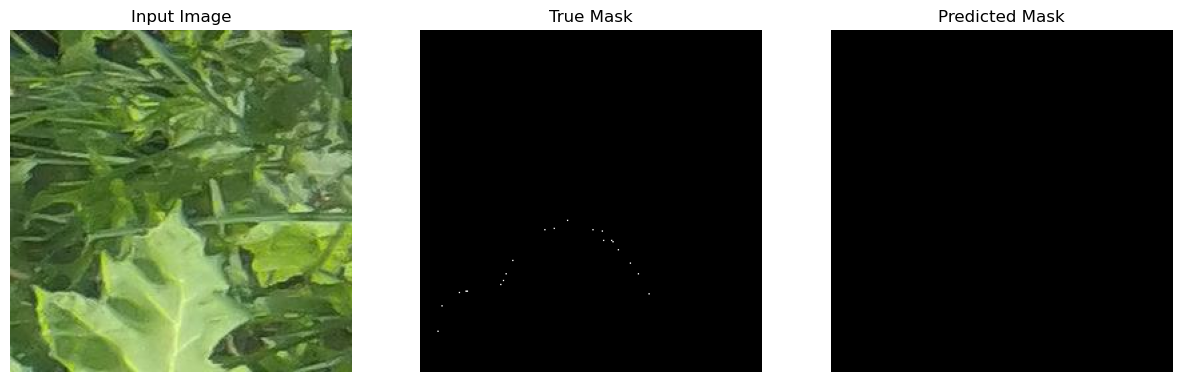

In [18]:
import matplotlib.pyplot as plt

def predict_and_display(model, image, true_mask):
    # Zorg ervoor dat de image en true_mask het juiste datatype hebben
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    if true_mask.dtype != np.uint8:
        true_mask = (true_mask * 255).astype(np.uint8)

    # Maak een voorspelling
    resized_image = cv2.resize(image, (image_size, image_size))
    resized_image = np.expand_dims(resized_image, axis=0)
    prediction = model.predict(resized_image)
    prediction = prediction.squeeze()

    # Zorg ervoor dat de prediction het juiste datatype heeft
    if prediction.dtype != np.uint8:
        prediction = (prediction * 255).astype(np.uint8)
    
    # Display de resultaten
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[0].axis('off')
    
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("True Mask")
    axs[1].axis('off')
    
    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')
    
    plt.show()

def find_non_empty_mask(X_val, y_val):
    for i in range(len(y_val)):
        if np.any(y_val[i]):  # Check of er enige non-zero waarde is in het masker
            return X_val[i], y_val[i]
    return None, None

# Vind een voorbeeldafbeelding met een niet-lege mask
test_image, true_mask = find_non_empty_mask(X_val, y_val)

if test_image is not None and true_mask is not None:
    predict_and_display(model, test_image, true_mask)
else:
    print("Geen niet-lege mask gevonden in de validatieset.")